MIT COVID-19 Datathon

Research Question: 
How did U.S. state-level shelter-in-place orders impact the proportion of COVID-19 positive cases (among those tested) and does this impact differ by socioeconomic status?

In [2]:
# import requirements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statistics as stat
from pylab import rcParams

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/smruthiramesh/MIT_COVID-19_Datathon/master/ny_county_data/ny_county_data.csv")
county_data = pd.read_csv("https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/counties.csv")

In [0]:
#joining with county data so we have population
df = df.set_index('FIPS').join(county_data.set_index('FIPS')['Density per square mile of land area - Population']).reset_index()

In [0]:
#dropping extra column
df.drop("Unnamed: 0",axis=1,inplace=True)
#renaming columns
df = df.rename(columns={'Density per square mile of land area - Population':'pop_density', 'transit_scores - population weighted averages aggregated from town/city level to county':'transit_scores'})

In [0]:
#create outcome variable - proportion of new daily positive COVID-19 cases 
df['proportion_cases'] = df['New Positives']/df['Total Number of Tests Performed']

In [7]:
#Exploring df
df.head(5)
df.tail(5)
df.dtypes

FIPS                                      int64
Median_Household_Income_2018            float64
transit_scores                          float64
Test Date                                object
New Positives                           float64
Cumulative Number of Positives          float64
Total Number of Tests Performed         float64
Cumulative Number of Tests Performed    float64
After Order                               int64
pop_density                             float64
proportion_cases                        float64
dtype: object

In [0]:
#dropping NA values in proportion cases resulting from days with 0 tests
df.dropna(axis=0,how='any',subset=['proportion_cases'],inplace=True)

In [9]:
print("Proportion of test data that is zero positive cases: ",df[df['proportion_cases']==0.0].shape[0]/df.shape[0])

Proportion of test data that is zero positive cases:  0.2895282529808191


We are going to select only the records where there is at least one positive case (citation:, reasoning:)

In [0]:
df = df[df['proportion_cases']!=0.0]

In [11]:
df[['New Positives', 'Total Number of Tests Performed', 'proportion_cases']].describe()

,New Positives,Total Number of Tests Performed,proportion_cases
count,2741.000000,2741.000000,2741.000000
mean,2761.903320,10925.080992,0.169103
std,10200.486143,30387.392679,0.148743
min,1.000000,4.000000,0.001616
25%,45.000000,540.000000,0.063636
50%,135.000000,1464.000000,0.123249
75%,650.000000,4717.000000,0.225082
max,135660.000000,295750.000000,1.000000


On average, there was a daily COVID-19 positive rate of  ~17% in NY State. 
We will test if this changed over time and if it changed before and after "New York State on PAUSE" executive order on March 22, 2020. 

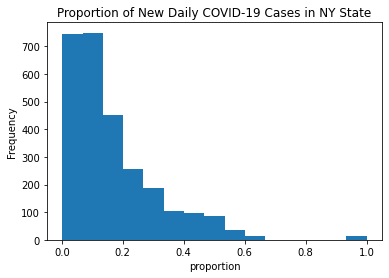

In [12]:
#histogram of outcome variable
plt.hist(df["proportion_cases"], bins = 15)
plt.xlabel("proportion")
plt.ylabel("Frequency")
plt.title("Proportion of New Daily COVID-19 Cases in NY State");

Outcome is right-skewed; looks like majority of proportions are between 0.0-0.12 (0-12% daily new cases in the state)

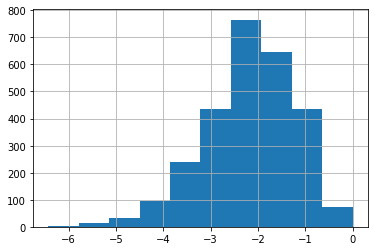

In [15]:
#log transform outcome 
df["proportion_cases"].apply(np.log).hist()
plt.show()

In [0]:
#creating a new column of log transformed values
df['log_proportion'] = df["proportion_cases"].apply(np.log)

Create new intervention variable for "New York State on PAUSE" similar to how researchers defined it in the ITS paper Pamela sent. 

"Pre-implementation (14 days prior, through three days after, implementation of the first statewide social distancing measure) versus post-implementation (four or more days after implementation). We selected this transition point based on estimates of the COVID-19 incubation period". https://www.medrxiv.org/content/10.1101/2020.04.03.20052373v2.full.pdf 

Our definition:
pre-pause dates: 14 days prior, through three days after, March 22, 2020 
March 8, 2020 - March 25, 2020 (including March 25)

post-pause dates: 4 or more days after March 22, 2020
March 26, 2020 - most current date


In [0]:
#sorting data by date
df = df.sort_values('Test Date')

In [0]:
#converting type to datetime for comparisons
df['dt_test_date'] = pd.to_datetime(df['Test Date'])

In [0]:
#Creating new binary intervention variable for "New York State on PAUSE"
df['After Order'] = np.where(df['dt_test_date'].apply(lambda x: x>= pd.to_datetime('03/26/2020').date()), 1, 0)

Create pre-pause time trend variable: assign a number to each unique date in ascending order, starting with 1. This variable will be our pre-pause trend variable.

In [0]:
#Creating new time variable for pre-pause trend

#total list of unique dates in df
total_range = df['Test Date'].unique()

dates_total = [str(x).split()[0] for x in total_range]
date_numbers = list(range(1,len(dates_total)+1))
mapping_dict = dict(list(zip(dates_total, date_numbers)))

#creating pre trend column
df['Pre Trend'] = df['Test Date'].apply(lambda x: mapping_dict[x])

Create another time variable to look at post-trend sustained effects: any date prior to March 26, 2020 gets a 0, and any dates on or after March 26, 2020 gets assigned a number in ascending order, starting with 1

In [0]:
#Creating new time variable for post-pause trend

post_range = df[df['After Order']==1]['Test Date'].unique()

#setting post trend values for dates from March 26 onwards
dates_post = [str(x).split()[0] for x in post_range]
post_numbers = list(range(1,len(dates_post)+1))
mapping_dict_post = dict(list(zip(dates_post, post_numbers)))

#setting post trend values for dates before March 26 
dates_pre = [x for x in total_range if x not in post_range]
pre_numbers = [0]*len(dates_pre)
mapping_dict_post.update(dict(list(zip(dates_pre, pre_numbers))))

#creating post trend column
df['Post Trend'] = df['Test Date'].apply(lambda x: mapping_dict_post[x])

Create a time series graph for log-outcome over time and mark the implementation date of NY State on PAUSE: March 22, 2020 and also mark 4 days after this, March 26, 2020

In [0]:
new_df = df.groupby('Test Date')['log_proportion'].mean().reset_index()

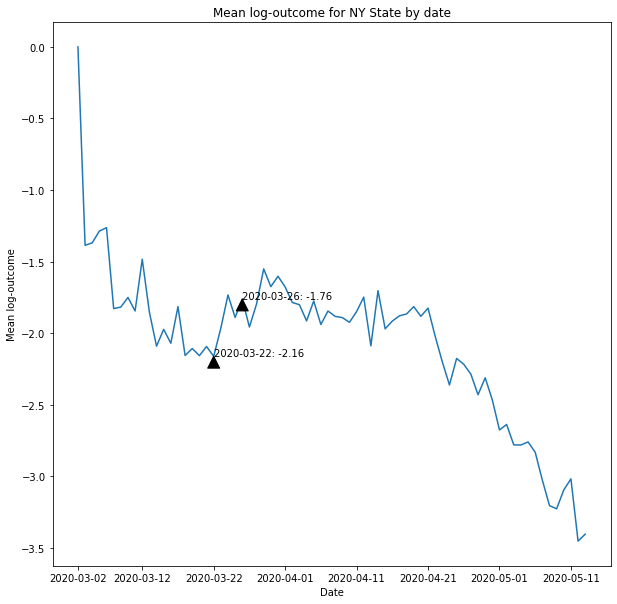

In [119]:
#date ranges for testing data (used for setting x ticks in plotting)
ranges = pd.date_range(min(df['Test Date']),max(df['Test Date']), freq='10D')
plot_dates = [str(x).split()[0] for x in ranges]

#outcome values at marker dates
o1= round(float(new_df[new_df['Test Date']=='2020-03-22']['log_proportion']),2)
o2 = round(float(new_df[new_df['Test Date']=='2020-03-26']['log_proportion']),2)

fig = plt.figure()
ax = fig.add_subplot(111)

#Creating time series graph
plt.plot(new_df['Test Date'], new_df['log_proportion'])
plt.xticks(plot_dates)

#creating markers
A = '2020-03-22','2020-03-26'
B = o1,o2
for xy in zip(A, B):
  ax.annotate('%s: %s' % xy, xy=xy, textcoords='data',arrowprops=dict(facecolor='black', shrink=0.05))

rcParams['figure.figsize'] = 10,10

plt.title("Mean log-outcome for NY State by date")
plt.xlabel("Date")
plt.ylabel("Mean log-outcome");

In [129]:
from google.colab import drive
drive.mount('drive')
df.to_csv('data.csv')
!cp data.csv "drive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


Create ITS mixed effects linear regression model

y = log proportion of new positive COVID-19 cases

x = post_pause (the binary intervention variable)

Other independent variables in model: pre-pause time, interaction term between pre-pause time and post_pause, post_trend

Include County random effect

If interaction term is statistically significant, then the intervention had an effect on the proportion of new COVID-19 cases

Work on including the income and maybe transit variable into the model afterwards
